<a href="https://colab.research.google.com/github/Dinusha-hue/Deep_Learning_Lab02/blob/main/FNN_Flight_Delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Mount Google Drive (if required)
drive.mount('/content/drive')

# Define the path to the dataset
path = "/content/drive/MyDrive/flights_sample_3m.csv"
df = pd.read_csv(path)
df.head()

Mounted at /content/drive


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [3]:
# Function to drop irrelevant columns
def drop_irrelevant_columns(data):
    columns_to_drop = ['CANCELLED', 'CANCELLATION_CODE', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
                       'TAXI_IN', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                       'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'DOT_CODE', 'AIRLINE_CODE',
                       'ORIGIN_CITY', 'DEST_CITY', 'AIRLINE_DOT', 'FL_NUMBER', 'DIVERTED']
    return data.drop(columns=[col for col in columns_to_drop if col in data.columns], axis=1)

# Function to extract date features
def extract_date_features(data):
    if 'FL_DATE' in data.columns:
        data['FL_DATE'] = pd.to_datetime(data['FL_DATE'], errors='coerce')
        data['DayOfWeek'] = data['FL_DATE'].dt.dayofweek
        data['Month'] = data['FL_DATE'].dt.month
        data['Day'] = data['FL_DATE'].dt.day
        data['Hour'] = data['CRS_DEP_TIME'].astype(str).str.zfill(4).str[:2].astype(int)
        data.drop(columns=['FL_DATE'], inplace=True)  # Drop original date column
    return data

# Function to encode categorical columns
def encode_categorical_columns(data):
    le = LabelEncoder()
    list_of_labels = ['AIRLINE', 'ORIGIN', 'DEST']

    for label in list_of_labels:
        if label in data.columns:
            data[label] = le.fit_transform(data[label])
    return data
# Function to handle missing values
def handle_missing_values(data):
    imputer = SimpleImputer(strategy='mean')
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Function to handle negative arrival delays
def filter_positive_arrival_delays(data):
    return data[data['ARR_DELAY'] > 0]

# Preprocessing pipeline
def preprocess_data(data):
    data = drop_irrelevant_columns(data)
    data = extract_date_features(data)
    data = encode_categorical_columns(data)
    data = handle_missing_values(data)
    return data

# Preprocess data
df = preprocess_data(df)

In [4]:
# Define features and target
features = df.drop(columns=['DEP_DELAY'])
target = np.where(df['DEP_DELAY'] > 15, 1, 0)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# Scale the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target (delay times)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [6]:
# Defineclassification model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))


# Output layer for
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

In [8]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
# Train the model
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=50, batch_size=128,
                    callbacks=[early_stopping])

Epoch 1/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.0559 - mae: 0.1376 - val_loss: 0.0189 - val_mae: 0.0677
Epoch 2/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0214 - mae: 0.0689 - val_loss: 0.0167 - val_mae: 0.0437
Epoch 3/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0186 - mae: 0.0615 - val_loss: 0.0093 - val_mae: 0.0334
Epoch 4/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 0.0163 - mae: 0.0568 - val_loss: 0.0097 - val_mae: 0.0286
Epoch 5/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 0.0158 - mae: 0.0561 - val_loss: 0.0106 - val_mae: 0.0323
Epoch 6/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 0.0146 - mae: 0.0541 - val_loss: 0.0073 - val_mae: 0.0220
Epoch 7/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 96s 5ms/step - loss: 0.0147 - mae: 0.0548 - val_loss: 0.0062 - val_mae: 0.0194
Epoch 8/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 0.0144 - mae: 0.0542 - val_loss: 0.0129 - val_mae: 0.0314
Epoch 9/50
14063

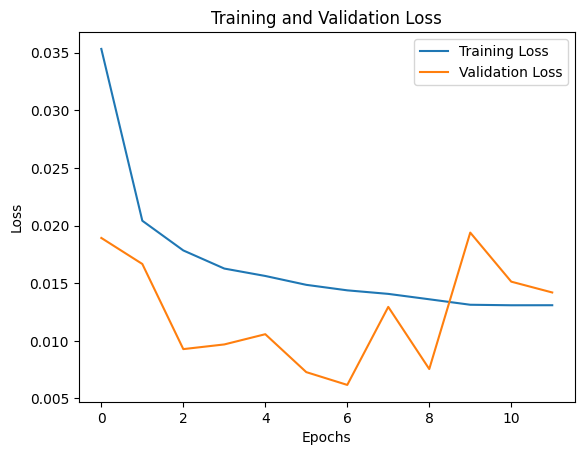

In [10]:
# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

In [12]:
print(f"Test loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

Test loss (MSE): 0.006328545045107603
Test MAE: 0.019532427191734314


In [13]:
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the scaled predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Check for zero values in y_test
non_zero_indices = np.nonzero(y_test)  # Get indices of non-zero values

if len(non_zero_indices[0]) == 0:
    print("Warning: y_test contains only zero values. Cannot compute MAPE.")
else:
    # Calculate Mean Absolute Percentage Error (only for non-zero values)
    mape = np.mean(np.abs((y_test[non_zero_indices] - y_pred[non_zero_indices]) / y_test[non_zero_indices])) * 100

    # Calculate accuracy
    accuracy = 100 - mape

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step


In [14]:
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: 7.48%
Accuracy: 92.52%


In [15]:
# Generate predictions on the test set
y_pred = model.predict(X_test_scaled)

# Inverse transform the predictions and true values (if you scaled them earlier)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2 Score): {r2}")

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
Mean Squared Error (MSE): 0.006328554864594712
Mean Absolute Error (MAE): 0.01953243894195805
R-squared (R2 Score): 0.9556177283668487
